In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten    
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [3]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [11]:
imagePaths = list(paths.list_images(r'C:\Users\chpujari2002\Documents\face_mask_detector\FMD\dataset'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
labels

C:\Users\chpujari2002\Documents\face_mask_detector\Face-Mask-Detection\mask_test\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
trainX, testX, trainY, testY = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [13]:
# load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 24s 3us/step


In [14]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers: layer.trainable = False

# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

C:\Users\chpujari2002\Documents\face_mask_detector\Face-Mask-Detection\mask_test\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [17]:
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
            steps_per_epoch=len(trainX) // BS,
            validation_data=(testX, testY),
            validation_steps=len(testX) // BS,
            epochs=EPOCHS)

Epoch 1/20
102/102 [==============================] - 183s 2s/step - loss: 0.5255 - accuracy: 0.7797 - val_loss: 0.1467 - val_accuracy: 0.9829
Epoch 2/20
102/102 [==============================] - 100s 970ms/step - loss: 0.1672 - accuracy: 0.9618 - val_loss: 0.0824 - val_accuracy: 0.9878
Epoch 3/20
102/102 [==============================] - 131s 1s/step - loss: 0.1159 - accuracy: 0.9681 - val_loss: 0.0665 - val_accuracy: 0.9866
Epoch 4/20
102/102 [==============================] - 128s 1s/step - loss: 0.0875 - accuracy: 0.9783 - val_loss: 0.0576 - val_accuracy: 0.9878
Epoch 5/20
102/102 [==============================] - 129s 1s/step - loss: 0.0720 - accuracy: 0.9811 - val_loss: 0.0514 - val_accuracy: 0.9866
Epoch 6/20
102/102 [==============================] - 128s 1s/step - loss: 0.0648 - accuracy: 0.9779 - val_loss: 0.0515 - val_accuracy: 0.9853
Epoch 7/20
102/102 [==============================] - 131s 1s/step - loss: 0.0632 - accuracy: 0.9802 - val_loss: 0.0465 - val_accuracy: 0.9

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

## Classification Report

In [19]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       433
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       819
   macro avg       0.99      0.99      0.99       819
weighted avg       0.99      0.99      0.99       819



## Save the Model

In [27]:
#save model:
model.save('mask_detector.h5', save_format="h5")

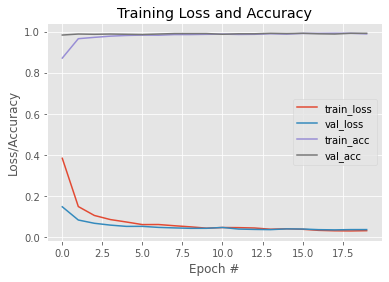

In [25]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig('acc.jpg')